In [1]:
from keras.datasets import cifar10
import os
import numpy as np

if os.path.exists('cifar10.npz'):
    f = np.load('cifar10.npz')
    x_train = f['x_train']
    x_test = f['x_test']
    y_train = f['y_train']
    y_test = f['y_test']
else:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    np.savez_compressed('cifar10', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    
x_train = x_train/255.
x_test = x_test/255.
y_train = np.eye(10)[y_train].squeeze()
y_trest = np.eye(10)[y_test].squeeze()

nb_val = 5000
x_val = x_train[:nb_val]
y_val = y_train[:nb_val]
x_train = x_train[nb_val:]
y_train = y_train[nb_val:]

Using TensorFlow backend.


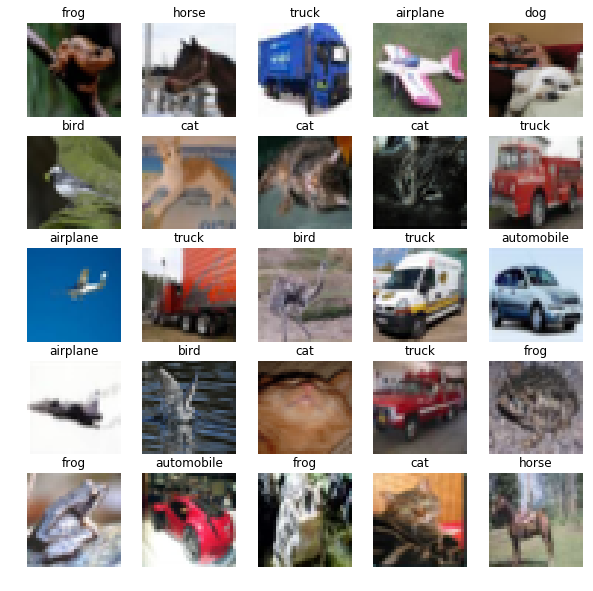

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

plt.figure(figsize=(10,10))
i = 0
for x,y in zip(x_train[:25],y_train[:25]):
    i += 1
    plt.subplot(5,5,i)
    plt.imshow(x)
    plt.title(labels[y.argmax()])
    plt.axis('off')

In [3]:
from keras.layers import Input, Dense, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

class CNN(object):
    '''
    入力
    →(畳み込み→プーリング) x N
    →Flatten
    →全結合 x M
    →出力
    '''
    def __init__(self, x_shape, y_shape, filters, kernels, fcnodes):
        self.x_shape = x_shape
        self.y_shape = y_shape
        self.filters = filters
        self.kernels = kernels
        self.fcnodes = fcnodes
        self.make_cnn()
    
    
    def make_cnn(self):
        x = h = Input(self.x_shape)
        
        for filter, kernel in zip(self.filters, self.kernels):
            h = Conv2D(filter, kernel, padding='same')(h)
            h = BatchNormalization()(h)
            h = Activation('relu')(h)
            h = MaxPooling2D((2,2))(h)
            
        h = Flatten()(h)
        
        for fcnode in self.fcnodes:
            h = Dense(fcnode)(h)
            h = BatchNormalization()(h)
            h = Activation('relu')(h)
        
        h = Dense(self.y_shape)(h)
        h = BatchNormalization()(h)
        y = Activation('softmax')(h)
        
        self.model = Model(x,y)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# ベースライン（mixupなし）

In [4]:
x_shape=(32,32,3)
y_shape=10
filters=[8,16,32]
kernels=[(3,3),(3,3),(3,3)]
fcnodes=[32,32]
epochs = 20

In [5]:
cnn1 = CNN(
    x_shape=x_shape,
    y_shape=y_shape,
    filters=filters,
    kernels=kernels,
    fcnodes=fcnodes
)

In [6]:
hist1 = cnn1.model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_val, y_val),
)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 51s - loss: 1.5604 - acc: 0.4507 - val_loss: 1.3832 - val_acc: 0.5142
Epoch 2/20
45000/45000 [==============================] - 51s - loss: 1.2541 - acc: 0.5607 - val_loss: 1.2102 - val_acc: 0.5796
Epoch 3/20
45000/45000 [==============================] - 52s - loss: 1.1331 - acc: 0.6044 - val_loss: 1.1449 - val_acc: 0.6022
Epoch 4/20
45000/45000 [==============================] - 52s - loss: 1.0645 - acc: 0.6266 - val_loss: 1.1274 - val_acc: 0.6136
Epoch 5/20
45000/45000 [==============================] - 52s - loss: 1.0149 - acc: 0.6427 - val_loss: 1.1539 - val_acc: 0.5926
Epoch 6/20
45000/45000 [==============================] - 52s - loss: 0.9719 - acc: 0.6620 - val_loss: 1.1293 - val_acc: 0.6046
Epoch 7/20
45000/45000 [==============================] - 52s - loss: 0.9419 - acc: 0.6716 - val_loss: 1.0824 - val_acc: 0.6302
Epoch 8/20
45000/45000 [==============================]

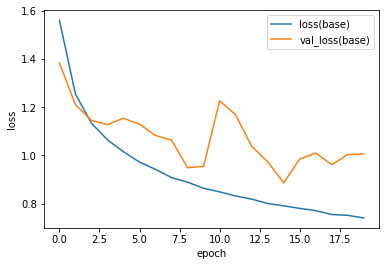

In [7]:
plt.plot(hist1.epoch, hist1.history['loss'], label='loss(base)')
plt.plot(hist1.epoch, hist1.history['val_loss'], label='val_loss(base)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

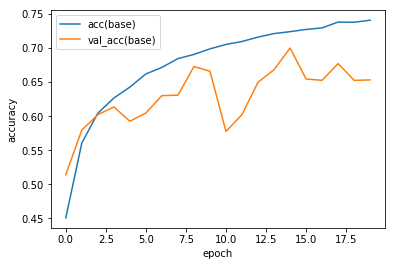

In [8]:
plt.plot(hist1.epoch, hist1.history['acc'], label='acc(base)')
plt.plot(hist1.epoch, hist1.history['val_acc'], label='val_acc(base)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

# mixupあり
- 単純に2つのデータを線形補間して新たなデータを作るだけ。
- 線形補間する際の重みはベータ分布からサンプリングする。αはハイパーパラメータ。

In [9]:
def make_mixup_samples(x_train, y_train, alpha=1.):
    # 訓練データから適当にサンプリングして2つのデータを用意する
    index1 = np.random.randint(low=0, high=len(x_train), size=len(x_train))
    index2 = np.random.randint(low=0, high=len(x_train), size=len(x_train))
    x1 = x_train[index1]
    y1 = y_train[index1]
    x2 = x_train[index2]
    y2 = y_train[index2]
    
    # λをベータ分布からサンプリング
    lam = np.random.beta(a=alpha, b=alpha, size=len(x_train))
    
    # λで重み付けして足す
    lamx = np.reshape(lam, (len(lam),1,1,1))
    lamy = np.reshape(lam, (len(lam),1))
    x_mix = lamx * x1 + (1. - lamx) * x2
    y_mix = lamy * y1 + (1. - lamy) * y2
    return (x_mix, y_mix)

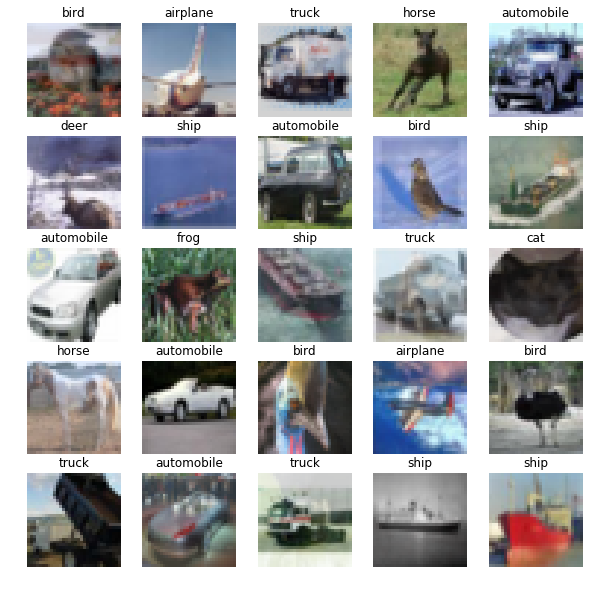

In [10]:
x_mix, y_mix = make_mixup_samples(x_train, y_train, alpha=0.2)

plt.figure(figsize=(10,10))
i = 0
for x,y in zip(x_mix[:25], y_mix[:25]):
    i += 1
    plt.subplot(5,5,i)
    plt.imshow(x)
    plt.title(labels[y.argmax()])
    plt.axis('off')

In [11]:
cnn2 = CNN(
    x_shape=x_shape,
    y_shape=y_shape,
    filters=filters,
    kernels=kernels,
    fcnodes=fcnodes
)

In [12]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        
loss = LossHistory()
loss.loss = []
loss.val_loss = []


class AccHistory(Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
acc = AccHistory()
acc.acc = []
acc.val_acc = []

In [13]:
for _ in range(epochs):
    x_mix, y_mix = make_mixup_samples(x_train, y_train, alpha=0.2)
    cnn2.model.fit(
        x=x_mix,
        y=y_mix,
        epochs=1,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[loss, acc]
    )

Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 53s - loss: 1.7025 - acc: 0.4295 - val_loss: 1.3751 - val_acc: 0.5192
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 51s - loss: 1.4423 - acc: 0.5408 - val_loss: 1.2793 - val_acc: 0.5486
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 51s - loss: 1.3304 - acc: 0.5896 - val_loss: 1.1576 - val_acc: 0.5956
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 51s - loss: 1.2745 - acc: 0.6158 - val_loss: 1.2438 - val_acc: 0.5700
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 55s - loss: 1.2388 - acc: 0.6252 - val_loss: 1.0783 - val_acc: 0.6260
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 54s - loss: 1.

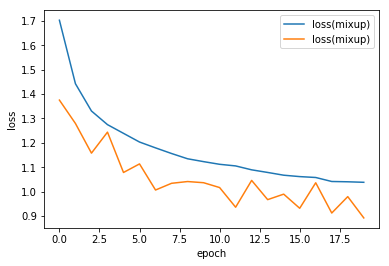

In [14]:
plt.plot(range(len(loss.loss)), loss.loss, label='loss(mixup)')
plt.plot(range(len(loss.val_loss)), loss.val_loss, label='loss(mixup)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

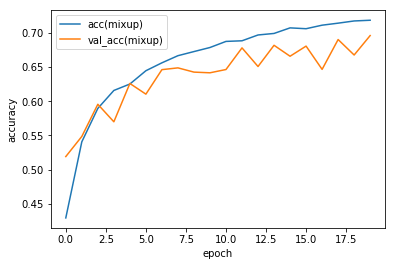

In [15]:
plt.plot(range(len(acc.acc)), acc.acc, label='acc(mixup)')
plt.plot(range(len(acc.val_acc)), acc.val_acc, label='val_acc(mixup)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

# ベースラインとmixupの比較

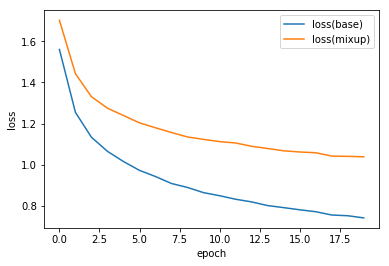

In [16]:
plt.plot(hist1.epoch, hist1.history['loss'], label='loss(base)')
plt.plot(range(len(loss.loss)), loss.loss, label='loss(mixup)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

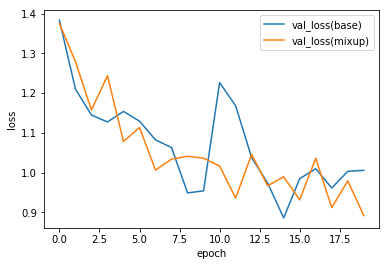

In [17]:
plt.plot(hist1.epoch, hist1.history['val_loss'], label='val_loss(base)')
plt.plot(range(len(loss.val_loss)), loss.val_loss, label='val_loss(mixup)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

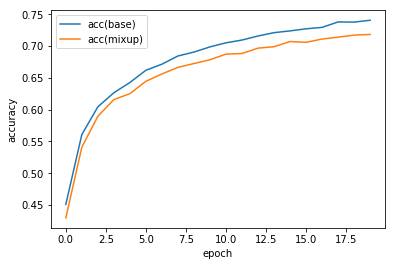

In [19]:
plt.plot(hist1.epoch, hist1.history['acc'], label='acc(base)')
plt.plot(range(len(acc.acc)), acc.acc, label='acc(mixup)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

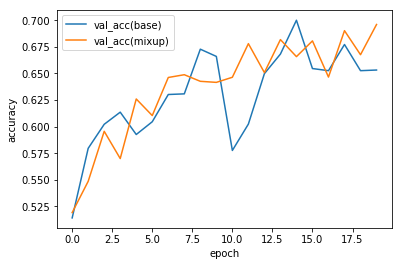

In [20]:
plt.plot(hist1.epoch, hist1.history['val_acc'], label='val_acc(base)')
plt.plot(range(len(acc.val_acc)), acc.val_acc, label='val_acc(mixup)')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')